<a href="https://colab.research.google.com/github/modelflows/notebooks/blob/main/deep-learning/modelFLows_ar_res_conv_ae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Autoregressive (AR) Residual Autoencoder
Official implementation of the AR Res. AE model to forecast flow dynamics of a laminar flow past a circular cylinder.

[R. Abadía-Heredia, A. Corrochano, M. Lopez-Martin and S. Le Clainche. "Generalization capabilities and robustness of hybrid machine learning models grounded in flow physics compared to purely deep learning models." 	arXiv:2404.17884 (2024)](https://doi.org/10.48550/arXiv.2404.17884)

**Description**

This model, which is based on a convolutional residual autoencoder model, forecast the dynamics of flow taking as input the snapshots from a numerical simulation.

Given the architecture of the model, to apply it to new datasets, the architecture has to be modified.

A GPU is required for a fast training of the Res. AE model and a minimum system RAM of 51 GB. However, the model can be loaded with weights from a previous successful training, allowing to compute predictions without training. The weights for this model can be found [here](https://drive.google.com/drive/folders/1kgr0hx5jE4cRNe6oLY9Un5xXMan4Nwqn?usp=sharing) under the name `weights_residual_ae_laminar.h5` and `weights_residual_encoder_laminar.h5`.

The key hyperameters are the following:

* ```vel_comp``` (str)      -> String defining which velocity component use for training the VAE model. The prediction will be done in the same component. The two options available are: "streamwise" or "wall_normal".
* ```inp_seq``` (int)       -> Number (> 1) of samples that enter as input to the POD-DL model.
* ```batch_size``` (int)    -> Number (> 4) of samples that defines the batch size that is used for training.
* ```num_preds``` (int)     -> Number (>= 1) of predictions to compute after training.
* ```train_size``` (float)  -> Percentage ((0,1)) of dataset to use for training the POD-DL model.

In [ ]:
try:
  import mat73
except:
  !pip install mat73
  import mat73

In [ ]:
!pip install -q tensorflow==2.15.0

In [ ]:
import sys
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time
import seaborn as sns

from skimage import img_as_float
from skimage.metrics import structural_similarity as ssim

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv2D, ConvLSTM2D, Conv2DTranspose, SeparableConv2D, Flatten, Reshape, LeakyReLU, ReLU, Input
from tensorflow.keras.layers import MaxPool2D, AveragePooling2D, UpSampling2D, TimeDistributed, LayerNormalization
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Dropout, BatchNormalization

In [ ]:
font = {'size'   : 18}

matplotlib.rc('font', **font)

In [ ]:
seed = 98374598
tf.random.set_seed(seed)
np.random.seed(seed)

# Hyperparameters

In [ ]:
vel_comp    = "streamwise" # streamwise or wall_normal
inp_seq     = 10
batch_size  = 8
num_preds   = 10
train_size  = 0.6

# Load Data

In [ ]:
data_dict = mat73.loadmat('DATA/dataset_laminar.mat')
Ten_orig = data_dict['Tensor'][:,:,:,:,100:]

# Data Split

In [ ]:
train_set = np.copy(Ten_orig[...,:int(train_size * Ten_orig.shape[-1])])
dev_set = np.copy(Ten_orig[...,int(train_size * Ten_orig.shape[-1]):int((train_size + 0.05) * Ten_orig.shape[-1])])
test_set = np.copy(Ten_orig[...,int((train_size + 0.05) * Ten_orig.shape[-1]):])

# Scailing between 0 and 1
ten_min = np.amin(train_set)
ten_range = np.ptp(train_set)
# ten_min = np.mean(train_set, axis = -1)[..., None]
# ten_range = np.std(train_set)

train_set = (train_set - ten_min)/ten_range
dev_set = (dev_set - ten_min)/ten_range
test_set = (test_set - ten_min)/ten_range

train_set = np.transpose(train_set, [4,1,2,3,0])
dev_set = np.transpose(dev_set, [4,1,2,3,0])
test_set = np.transpose(test_set, [4,1,2,3,0])

print(f"Train set shape: {train_set.shape}")
print(f"Dev set shape: {dev_set.shape}")
print(f"Test set shape: {test_set.shape}")

Train set shape: (299, 100, 40, 64, 3)
Dev set shape: (25, 100, 40, 64, 3)
Test set shape: (175, 100, 40, 64, 3)


# Data Windowing

In [ ]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, samplingRate, batch_size, case="training",
            train_df=train_set, val_df=dev_set, test_df=test_set):

        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.sampling_rate = samplingRate

        # Store case
        self.case = case

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}'])

def split_window(self, features):

    inputs = features[:, self.input_slice, ...]
    labels = features[:, self.labels_slice, ...]

    inputs.set_shape([None, self.input_width, None, None, None])
    labels.set_shape([None, self.label_width, None, None, None])

    return inputs, labels

WindowGenerator.split_window = split_window

def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    if self.case == "training":
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            sampling_rate=self.sampling_rate,
            shuffle=True,
            batch_size=self.batch_size)

    else:
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=self.total_window_size,
            shuffle=False,
            batch_size=self.batch_size)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    # Get and cache an example batch of 'inputs, labels' for plotting.
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the '.train' dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
def window_generator(inputWidth, batch_size):

  labelWidth=1
  shift=1

  w1 = WindowGenerator(input_width = inputWidth, label_width = labelWidth,
                      shift = shift, samplingRate = 1, batch_size = batch_size,
                      train_df = train_set[:,:,:,0,:], val_df = dev_set[:,:,:,0,:],
                       test_df = test_set[:,:,:,0,:])

  w_train = w1.train
  w_val = w1.val

  for i in range(1,Ten_orig.shape[-2]):
    w2 = WindowGenerator(input_width = inputWidth, label_width = labelWidth,
                      shift = shift, samplingRate = 1, batch_size = batch_size,
                      train_df = train_set[:,:,:,i,:], val_df = dev_set[:,:,:,i,:],
                      test_df = test_set[:,:,:,i,:])

    w_train = w_train.concatenate(w2.train)
    w_val = w_val.concatenate(w2.val)

  del w1, w2

  return w_train, w_val

In [ ]:
w_train, w_val = window_generator(inp_seq, batch_size)

In [ ]:
print(f"Number of training batches: {len(w_train)}")

for example_inputs, example_labels in w_train.take(1):
  in_shape = (example_inputs.shape[1],example_inputs.shape[2],example_inputs.shape[3],example_inputs.shape[4])
  print(f'\nInputs shape (batch size, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch size, time, features): {example_labels.shape}')

Number of training batches: 2368

Inputs shape (batch size, time, features): (8, 10, 100, 40, 3)
Labels shape (batch size, time, features): (8, 1, 100, 40, 3)


# Autoencoder

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
def identity_block(in_shape, filters=12, name=None):
  block_in = Input(shape=in_shape)
  x_1 = block_in
  print(block_in.shape)
  x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same',
             data_format='channels_last', use_bias = False, activation = None,
             kernel_initializer = 'he_normal')(block_in)
  x = LayerNormalization()(x)
  x = ReLU()(x)
  x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same',
             data_format='channels_last', use_bias = False, activation = None,
             kernel_initializer = 'he_normal')(x)
  x = LayerNormalization()(x)
  x = Add()([x,x_1])
  block_out = ReLU()(x)

  return Model(inputs=block_in, outputs=block_out, name=name)

(None, 10, 100, 40, 3)


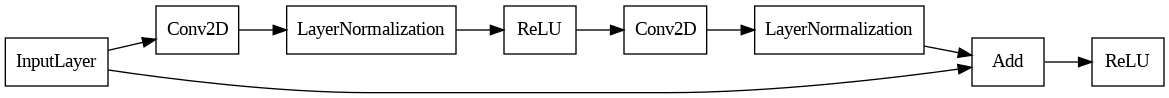

In [ ]:
model = identity_block(in_shape, 3)

tf.keras.utils.plot_model(model, show_layer_names=False, rankdir='LR')

In [ ]:
def conv_block(in_shape, filters=12, name=None):
  block_in = Input(shape=in_shape)
  x_1 = block_in

  x = Conv2D(filters=filters, kernel_size=3, strides=2, padding='same',
             data_format='channels_last', use_bias = False, activation = None,
             kernel_initializer = 'he_normal')(block_in)
  x = LayerNormalization()(x)
  x = ReLU()(x)
  x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same',
             data_format='channels_last', use_bias = False, activation = None,
             kernel_initializer = 'he_normal')(x)
  x = LayerNormalization()(x)
  x_1 = Conv2D(filters=filters, kernel_size=1, strides=2, padding='valid',
             data_format='channels_last', use_bias = False, activation = None,
             kernel_initializer = 'he_normal')(x_1)
  x = Add()([x,x_1])
  block_out = ReLU()(x)

  return Model(inputs=block_in, outputs=block_out, name=name)

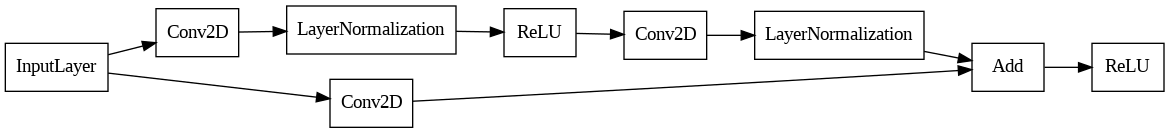

In [ ]:
model = conv_block(in_shape)

tf.keras.utils.plot_model(model, show_layer_names=False, rankdir='LR')

In [ ]:
res_in = Input(shape=in_shape)

x = Conv2D(filters=16, kernel_size=(3,3), strides=(2,1), padding='valid',
            activation=None, data_format='channels_last',
            kernel_initializer='he_normal')(res_in)
x = LayerNormalization()(x)
x = ReLU()(x)
x = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='valid',
            activation=None, data_format='channels_last',
            kernel_initializer='he_normal')(x)
x = LayerNormalization()(x)
x = ReLU()(x)

for i in range(3):
  name = 'identity_block_' + str(i)
  x = identity_block(x.shape[1:], filters=32, name=name)(x)

x = conv_block(x.shape[1:], filters=64, name='conv_block_1')(x)

for i in range(3):
  name = 'identity_block_' + str(i+3)
  x = identity_block(x.shape[1:], filters=64, name=name)(x)

res_out = x

res_encoder = Model(inputs=res_in, outputs=res_out, name='res_encoder')

(None, 10, 47, 36, 32)
(None, 10, 47, 36, 32)
(None, 10, 47, 36, 32)
(None, 10, 24, 18, 64)
(None, 10, 24, 18, 64)
(None, 10, 24, 18, 64)


In [ ]:
res_encoder.summary()

Model: "res_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10, 100, 40, 3)   0         
                             ]                                   
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 49, 38, 16)    448       
                                                                 
 layer_normalization_4 (Lay  (None, 10, 49, 38, 16)    32        
 erNormalization)                                                
                                                                 
 re_lu_4 (ReLU)              (None, 10, 49, 38, 16)    0         
                                                                 
 conv2d_6 (Conv2D)           (None, 10, 47, 36, 32)    4640      
                                                                 
 layer_normalization_5 (Lay  (None, 10, 47, 36, 32)    

In [ ]:
dec_in = Input(shape=(24,18,128))

x = Conv2DTranspose(filters=64, kernel_size=(3,3), strides=(2,2), padding='valid',
                    data_format='channels_last', activation = None,
                    use_bias = False, kernel_initializer = 'he_normal')(dec_in)
x = LayerNormalization()(x)
x = ReLU()(x)

x = Conv2DTranspose(filters=32, kernel_size=(4,4), strides=(2,1),
                    padding='valid', data_format='channels_last',
                    activation = None, use_bias = False,
                    kernel_initializer = 'he_normal')(x)
x = LayerNormalization()(x)
x = ReLU()(x)

x = Conv2D(filters=3, kernel_size=(1,1), activation = None, use_bias = False,
                    kernel_initializer = 'glorot_uniform')(x)

x = Reshape((1,x.shape[1],x.shape[2],x.shape[3]))(x)

dec_out = x

res_decoder = Model(inputs=dec_in, outputs=dec_out, name='res_decoder')

In [ ]:
res_decoder.summary()

Model: "res_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 24, 18, 128)]     0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 49, 37, 64)        73728     
 anspose)                                                        
                                                                 
 layer_normalization_20 (La  (None, 49, 37, 64)        128       
 yerNormalization)                                               
                                                                 
 re_lu_20 (ReLU)             (None, 49, 37, 64)        0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 100, 40, 32)       32768     
 Transpose)                                                      
                                                       

In [ ]:
hidden_in = Input(shape=(inp_seq, 24, 18, 64))

x = ConvLSTM2D(128, (3, 3), padding="same", return_sequences=False,
                 data_format='channels_last', dropout=0.0, use_bias = False,
                 recurrent_dropout=0.0)(hidden_in)
x = LayerNormalization()(x)

hidden_out = x

hidden = Model(inputs=hidden_in, outputs=hidden_out, name='hidden')

In [ ]:
hidden.summary()

Model: "hidden"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 10, 24, 18, 64)   0         
                             ]                                   
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 24, 18, 128)       884736    
                                                                 
 layer_normalization_22 (La  (None, 24, 18, 128)       256       
 yerNormalization)                                               
                                                                 
Total params: 884992 (3.38 MB)
Trainable params: 884992 (3.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
tf.keras.backend.clear_session()

input_DCA = Input(shape=in_shape)

x_enc = res_encoder(input_DCA)

x_hidden = hidden(x_enc)

out_DCA = res_decoder(x_hidden)

model_autoencoder = Model(inputs=input_DCA, outputs=out_DCA, name='residual_autoencoder')

In [ ]:
model_autoencoder.summary()

Model: "residual_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 100, 40, 3)   0         
                             ]                                   
                                                                 
 res_encoder (Functional)    (None, 10, 24, 18, 64)    340416    
                                                                 
 hidden (Functional)         (None, 24, 18, 128)       884992    
                                                                 
 res_decoder (Functional)    (None, 1, 100, 40, 3)     106784    
                                                                 
Total params: 1332192 (5.08 MB)
Trainable params: 1332192 (5.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# 5. Training (IF the model was not previously trained)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

t0 = time.time()

model_autoencoder.compile(optimizer=optimizer, loss='mse')
history=model_autoencoder.fit(w_train, epochs=30, validation_data=w_val)

t1 = time.time()
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

## Plot Loss evolution

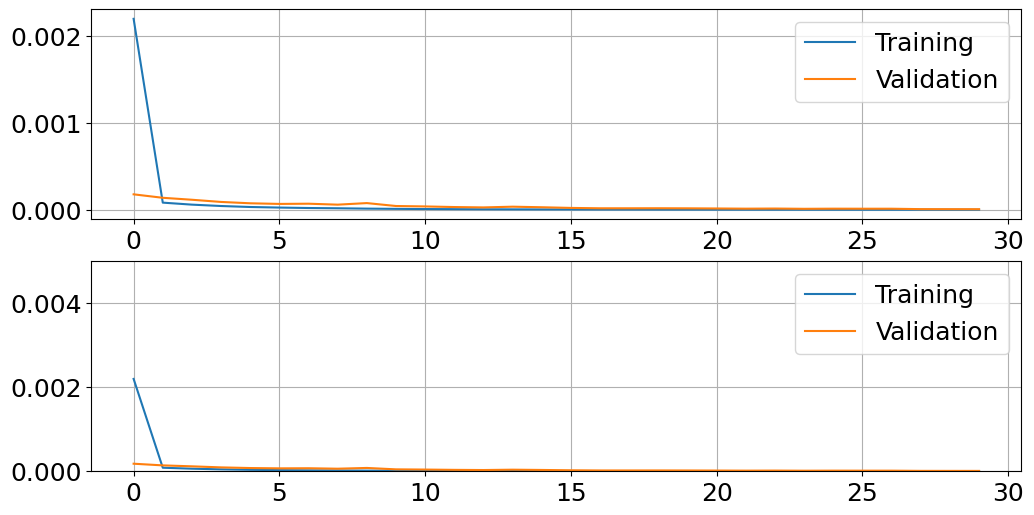

In [ ]:
# plt.close('all')

# fig_loss = plt.figure(figsize=(12,6))
# plt.subplot(2, 1, 1)
# plt.plot(history.history["loss"], label='Training')
# plt.plot(history.history["val_loss"], label='Validation')
# plt.legend()
# plt.grid(True, which='both')

# ax = plt.subplot(2, 1, 2)
# ax.set_ylim(0, 0.005)
# plt.plot(history.history["loss"], label='Training')
# plt.plot(history.history["val_loss"], label='Validation')
# plt.legend()
# plt.grid(True, which='both')

## Load weights from a pretrained model

In [ ]:
file_name = f"Models_weights/weights_residual_ae_laminar.h5"
model_autoencoder.load_weights(file_name)

file_name = f"Models_weights/weights_residual_encoder_laminar.h5"
res_encoder.load_weights(file_name)

# Prediction

In [ ]:
def evaluate_model_test_iter(ten_orig_1, time_pred = 10, start_pnt = 10):

  ten_orig = np.copy(ten_orig_1)

  predictions = np.empty((ten_orig.shape[0], ten_orig.shape[1],
                          ten_orig.shape[2], ten_orig.shape[3], time_pred))

  snap = np.copy(ten_orig[..., start_pnt - 10 : start_pnt])
  snap = (snap - ten_min) / ten_range
  snap = np.transpose(snap, [3, 4, 1, 2, 0])

  for i in range(time_pred):

    pred = model_autoencoder.predict(snap, verbose = 0)

    pred_1 = np.transpose(np.copy(pred[:, 0, :, :, :]), [3, 1, 2, 0])
    pred_1 = pred_1 * ten_range + ten_min

    predictions[...,i] = pred_1

    snap = np.concatenate([snap[:,1:,:,:,:], pred], axis = 1)

  del ten_orig, snap, pred, pred_1

  return predictions

In [ ]:
t0 = time.time()

start_pnt = train_set.shape[0]
predictions = evaluate_model_test_iter(Ten_orig, num_preds, start_pnt)

t1 = time.time()
print("Seconds elapsed: %f" % (t1 - t0))

Seconds elapsed: 47.182142


Text(0.5, 1.0, 'Forecast')

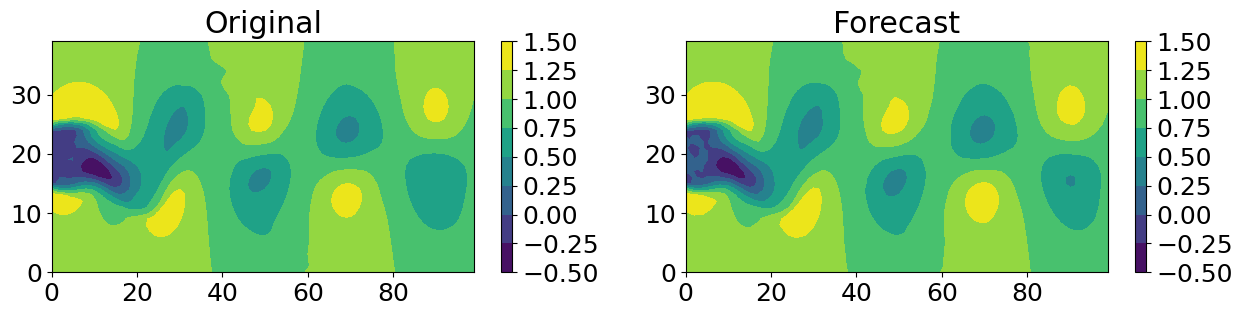

In [ ]:
select_snap = 9
comp = 0
span_ch = 32

snap_pred = predictions[comp, :, :, span_ch, select_snap]
snap_target = Ten_orig[comp, :, :, span_ch, start_pnt + select_snap]

fig3 = plt.figure(figsize=(15, 3))

vmin = np.amin(snap_target)
vmax = np.amax(snap_target)

plt.subplot(1, 2, 1)
plt.contourf(snap_target.T, vmin = vmin, vmax = vmax)
plt.colorbar()
plt.title("Original")

plt.subplot(1, 2, 2)
plt.contourf(snap_pred.T, vmin = vmin, vmax = vmax)
plt.colorbar()
plt.title("Forecast")

# Plot latent space

In [ ]:
for batch in w_train:
  in_, out_ = batch

  break

print(in_.shape)

(8, 10, 100, 40, 3)


In [ ]:
_1 = res_encoder.predict(in_)

1/1 [==============================] - 3s 3s/step


In [ ]:
print(f"Latent space shape: {_1.shape}")

Latent space shape: (8, 10, 24, 18, 64)


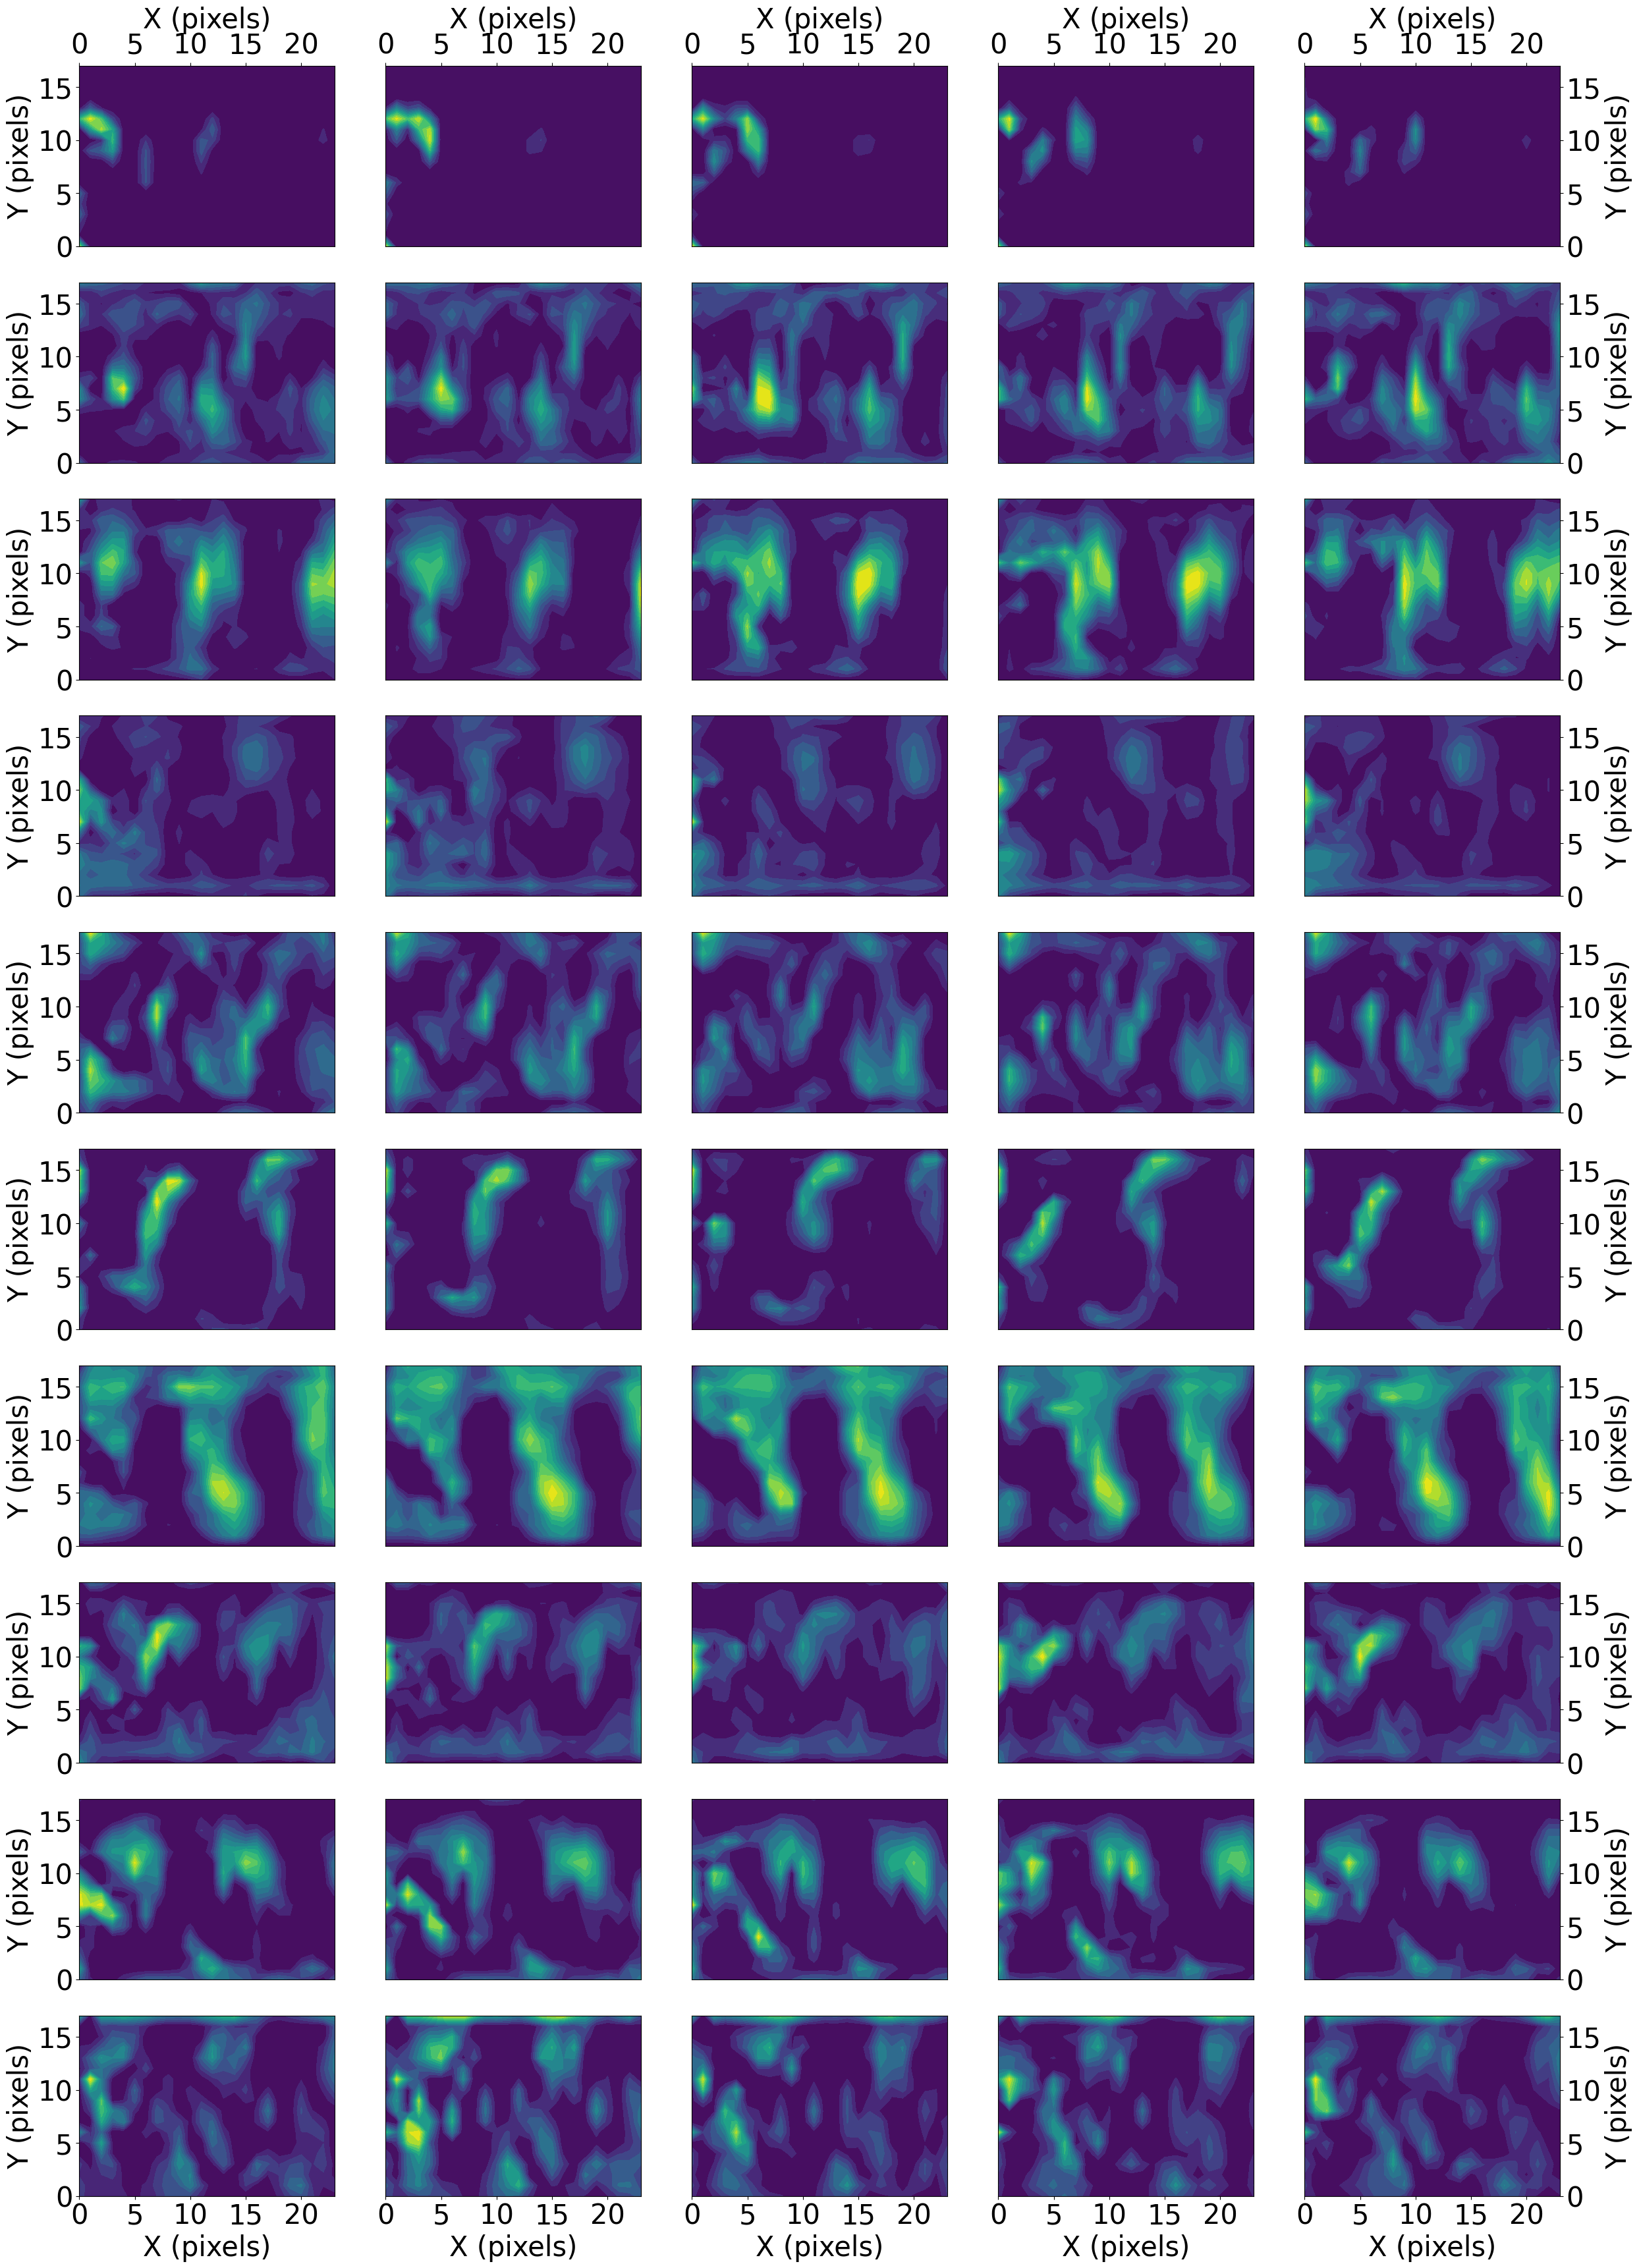

In [ ]:
font = {'size'   : 30}

matplotlib.rc('font', **font)

fig, axs = plt.subplots(10, 5, figsize = (29, 42))

for i in range(5):
  axs[0,i].contourf(_1[0, i, :, :,0].T, 13)
  # axs[0,i].axis(False)
  axs[0,i].xaxis.tick_top()
  axs[0,i].set_xlabel("X (pixels)")
  axs[0,i].xaxis.set_label_position('top')
  if (i != 0 and i != 4):
    axs[0,i].get_yaxis().set_visible(False)
  if (i == 4):
    axs[0,i].yaxis.tick_right()
    axs[0,i].set_ylabel("Y (pixels)")
    axs[0,i].yaxis.set_label_position('right')
  if (i == 0):
    axs[0,i].set_ylabel("Y (pixels)")

  axs[1,i].contourf(_1[0, i, :, :,1].T, 13)
  axs[1,i].get_xaxis().set_visible(False)
  if (i != 0 and i != 4):
    axs[1,i].get_yaxis().set_visible(False)
  if (i == 4):
    axs[1,i].yaxis.tick_right()
    axs[1,i].set_ylabel("Y (pixels)")
    axs[1,i].yaxis.set_label_position('right')
  if (i == 0):
    axs[1,i].set_ylabel("Y (pixels)")

  axs[2,i].contourf(_1[0, i, :, :,2].T, 13)
  axs[2,i].get_xaxis().set_visible(False)
  if (i != 0 and i != 4):
    axs[2,i].get_yaxis().set_visible(False)
  if (i == 4):
    axs[2,i].yaxis.tick_right()
    axs[2,i].set_ylabel("Y (pixels)")
    axs[2,i].yaxis.set_label_position('right')
  if (i == 0):
    axs[2,i].set_ylabel("Y (pixels)")

  axs[3,i].contourf(_1[0, i, :, :,3].T, 13)
  axs[3,i].get_xaxis().set_visible(False)
  if (i != 0 and i != 4):
    axs[3,i].get_yaxis().set_visible(False)
  if (i == 4):
    axs[3,i].yaxis.tick_right()
    axs[3,i].set_ylabel("Y (pixels)")
    axs[3,i].yaxis.set_label_position('right')
  if (i == 0):
    axs[3,i].set_ylabel("Y (pixels)")

  axs[4,i].contourf(_1[0, i, :, :,4].T, 13)
  axs[4,i].get_xaxis().set_visible(False)
  if (i != 0 and i != 4):
    axs[4,i].get_yaxis().set_visible(False)
  if (i == 4):
    axs[4,i].yaxis.tick_right()
    axs[4,i].set_ylabel("Y (pixels)")
    axs[4,i].yaxis.set_label_position('right')
  if (i == 0):
    axs[4,i].set_ylabel("Y (pixels)")

  axs[5,i].contourf(_1[0, i, :, :,9].T, 13)
  axs[5,i].get_xaxis().set_visible(False)
  if (i != 0 and i != 4):
    axs[5,i].get_yaxis().set_visible(False)
  if (i == 4):
    axs[5,i].yaxis.tick_right()
    axs[5,i].set_ylabel("Y (pixels)")
    axs[5,i].yaxis.set_label_position('right')
  if (i == 0):
    axs[5,i].set_ylabel("Y (pixels)")

  axs[6,i].contourf(_1[0, i, :, :,19].T, 13)
  axs[6,i].get_xaxis().set_visible(False)
  if (i != 0 and i != 4):
    axs[6,i].get_yaxis().set_visible(False)
  if (i == 4):
    axs[6,i].yaxis.tick_right()
    axs[6,i].set_ylabel("Y (pixels)")
    axs[6,i].yaxis.set_label_position('right')
  if (i == 0):
    axs[6,i].set_ylabel("Y (pixels)")

  axs[7,i].contourf(_1[0, i, :, :,34].T, 13)
  axs[7,i].get_xaxis().set_visible(False)
  if (i != 0 and i != 4):
    axs[7,i].get_yaxis().set_visible(False)
  if (i == 4):
    axs[7,i].yaxis.tick_right()
    axs[7,i].set_ylabel("Y (pixels)")
    axs[7,i].yaxis.set_label_position('right')
  if (i == 0):
    axs[7,i].set_ylabel("Y (pixels)")

  axs[8,i].contourf(_1[0, i, :, :,54].T, 13)
  axs[8,i].get_xaxis().set_visible(False)
  if (i != 0 and i != 4):
    axs[8,i].get_yaxis().set_visible(False)
  if (i == 4):
    axs[8,i].yaxis.tick_right()
    axs[8,i].set_ylabel("Y (pixels)")
    axs[8,i].yaxis.set_label_position('right')
  if (i == 0):
    axs[8,i].set_ylabel("Y (pixels)")

  axs[9,i].contourf(_1[0, i, :, :,63].T, 13)
  axs[9,i].set_xlabel("X (pixels)")
  if (i != 0 and i != 4):
    axs[9,i].get_yaxis().set_visible(False)
  if (i == 4):
    axs[9,i].yaxis.tick_right()
    axs[9,i].set_ylabel("Y (pixels)")
    axs[9,i].yaxis.set_label_position('right')
  if (i == 0):
    axs[9,i].set_ylabel("Y (pixels)")

font = {'size'   : 18}

matplotlib.rc('font', **font)